## Emotion Detection with SVM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [2]:
path_emotion_file = "isear.csv"

# read csv
df_file = pd.read_csv(path_emotion_file, error_bad_lines=False, warn_bad_lines=False, sep='|', encoding='latin1')

df = df_file[['Field1', 'SIT']]  # Field1 target, SIT feature


emotion_groups = df.groupby('Field1').size()

count_vector = TfidfVectorizer(ngram_range=(1, 2))  # bigram

In [3]:
accuracy_svm = list()
accuracy_lr = list()

#### Emotion Detection with SVM

In [5]:
for i in range(20):
    train, test = train_test_split(df, test_size=0.3, shuffle=True)

    vectors = count_vector.fit_transform(train.SIT)
    vectors_test = count_vector.transform(test.SIT)
    
    clf = LinearSVC()
    clf.fit(vectors, train.Field1)

    predict = clf.predict(vectors_test)

    accuracy_svm.append(np.mean(predict == test.Field1))

np.mean(accuracy_svm)

0.5916259440248778

#### Emotion Detection with Logistic Regression 

In [6]:
for i in range(20):
    train, test = train_test_split(df, test_size=0.3, shuffle=True)



    vectors = count_vector.fit_transform(train.SIT)


    vectors_test = count_vector.transform(test.SIT)
    clf = LogisticRegression()
    clf.fit(vectors, train.Field1)

    predict = clf.predict(vectors_test)

    accuracy_lr.append(np.mean(predict == test.Field1))

np.mean(accuracy_lr)

0.574300310972901

### SVM vs. Logistic Regression 

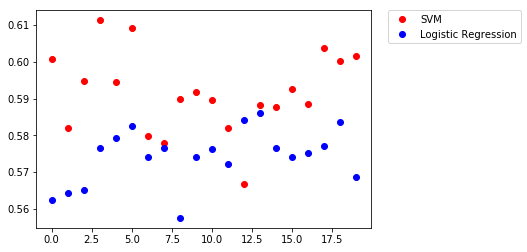

In [7]:
%matplotlib inline
plt.subplot()
plt.plot(accuracy_svm, 'o',color='red', label='SVM') # SVM

plt.subplot()
plt.plot(accuracy_lr, 'o',color='blue', label='Logistic Regression') # logistic regression

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

### Model Selection for SVM

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

In [9]:
# ref: https://scikit-learn.org/stable/modules/feature_extraction.html#customizing-the-vectorizer-classes

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [12]:
train, test = train_test_split(df, test_size=0.3, shuffle=True)

algorithms_estimator = Pipeline([
    ('vect', TfidfVectorizer()),
    ('svm', LinearSVC()),
])

parameters = {
    #'svm__random_state': [None, np.random.randint(100)],
    #'svm__max_iter': [1000, 10000],
    'vect__tokenizer': [None, LemmaTokenizer()],
    'vect__ngram_range': [(1,1), (1,2), (1,3)],
    'vect__stop_words': [None, 'english'],
    'vect__smooth_idf': [True, False],
}

clf = GridSearchCV(algorithms_estimator, parameters, cv=8, n_jobs=8)
clf.fit(train.SIT, train.Field1)
result=clf.cv_results_

In [13]:
import warnings
warnings.filterwarnings('ignore')

result_df = pd.DataFrame(result)
result_df = result_df[['rank_test_score', 'param_vect__stop_words', 'param_vect__smooth_idf', 'param_vect__ngram_range', 'param_vect__tokenizer', 'mean_test_score']]
result_df = result_df.sort_values(by="rank_test_score")
result_df.head()

,rank_test_score,param_vect__stop_words,param_vect__smooth_idf,param_vect__ngram_range,param_vect__tokenizer,mean_test_score
9,1,None,True,"(1, 2)",<__main__.LemmaTokenizer object at 0x7fe87c4b5...,0.591394
13,1,None,False,"(1, 2)",<__main__.LemmaTokenizer object at 0x7fe87c4b5...,0.591394
21,3,None,False,"(1, 3)",<__main__.LemmaTokenizer object at 0x7fe87c4b5...,0.591203
17,4,None,True,"(1, 3)",<__main__.LemmaTokenizer object at 0x7fe87c4b5...,0.590823
8,5,None,True,"(1, 2)",None,0.586824


In [4]:
train, test = train_test_split(df, test_size=0.3, shuffle=True)

vectors = count_vector.fit_transform(train.SIT)


vectors_test = count_vector.transform(test.SIT)
clf = LogisticRegression()
clf.fit(vectors, train.Field1)

predict = clf.predict(vectors_test)

accuracy_lr.append(np.mean(predict == test.Field1))

D:\Anaconda3\envs\workplace\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\envs\workplace\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [7]:
np.mean(predict==test.Field1)

0.543758329631275

In [8]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if normalize:
    	plt.savefig("normalized_confusionwl.png")
    else:
    	plt.savefig("confusionwl.png")

In [11]:
test.Field1.unique()

array(['shame', 'fear', 'guilt', 'anger', 'disgust', 'joy', 'sadness'],
      dtype=object)

Confusion matrix, without normalization
[[151  39  35  43  12  21  24]
 [ 49 174  31  22  14  13  18]
 [ 17  10 213  18  15  17  16]
 [ 53  10  30 146   7  21  37]
 [ 13  22  19  21 230  26   9]
 [ 37  13  20  22  27 178  18]
 [ 34  30  42  64  26  12 132]]
Normalized confusion matrix
[[0.46 0.12 0.11 0.13 0.04 0.06 0.07]
 [0.15 0.54 0.1  0.07 0.04 0.04 0.06]
 [0.06 0.03 0.7  0.06 0.05 0.06 0.05]
 [0.17 0.03 0.1  0.48 0.02 0.07 0.12]
 [0.04 0.06 0.06 0.06 0.68 0.08 0.03]
 [0.12 0.04 0.06 0.07 0.09 0.57 0.06]
 [0.1  0.09 0.12 0.19 0.08 0.04 0.39]]


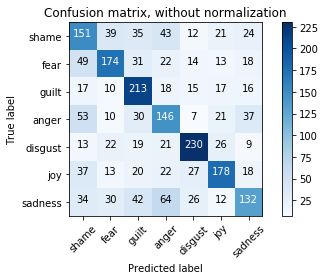

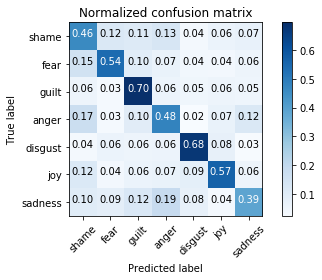

In [12]:
import numpy as np

cnf_matrix = confusion_matrix(test.Field1, predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=test.Field1.unique(),
                      title='Confusion matrix, without normalization')

plot_confusion_matrix(cnf_matrix, classes=test.Field1.unique(), normalize=True,
                      title='Normalized confusion matrix')